# Data block API foundations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_07a import *

In [3]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

# Image ItemList

We leave the images on disk and just grab the ones we need for each mini-batch as we use them.

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/bf/.fastai/data/imagenette-160')

In [5]:
#export
import PIL, os, mimetypes
Path.ls = lambda x: list(x.iterdir())

In [6]:
path.ls()

[PosixPath('/home/bf/.fastai/data/imagenette-160/train'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val')]

In [7]:
(path/'val').ls()

[PosixPath('/home/bf/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n01440764'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n02979186')]

In [8]:
path_tench = path/'val'/'n01440764'

In [9]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/bf/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00000293.JPEG')

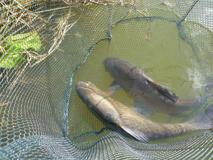

In [10]:
img = PIL.Image.open(img_fn)
img

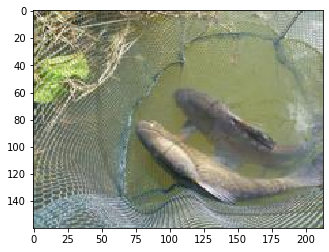

In [11]:
plt.imshow(img)

In [12]:
import numpy
imga = numpy.array(img)

In [13]:
imga.shape

(160, 213, 3)

In [14]:
imga[:10, :10, 0]

array([[115, 153, 187, 173, ..., 115,  69, 141, 154],
       [149, 190, 208, 182, ...,  98, 134,  97, 102],
       [202, 171, 147, 176, ..., 113,  74,  49,  93],
       [ 75, 204, 152,  70, ...,  66,  80,  55,  97],
       ...,
       [ 99,  66, 130, 189, ..., 241, 237, 189, 212],
       [188, 123, 147, 207, ..., 189, 189, 187, 223],
       [198, 133, 130, 165, ..., 182, 214, 168, 179],
       [176, 153, 139, 152, ..., 117, 133, 189, 112]], dtype=uint8)

Just in case there are other files in the directory (models, texts...) we want to keep only the images. Let's not write it out by hand, but instead use what's already on our computer (the MIME types database).

In [15]:
#export
image_extensions = set(k for k, v in mimetypes.types_map.items() if v.startswith('image/'))

In [16]:
''.join(image_extensions)

'.jpe.gif.ras.pbm.xpm.ico.pgm.rgb.tif.jpeg.jpg.xwd.svg.pnm.ief.bmp.ppm.tiff.png.xbm'

In [17]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

Walk through the directories and grab all the images. 

In [18]:
#export 
def _get_files(p, fs, extensions=None):
    p = Path(p) # make sure it can pass str or pathlib object
    # not system file, is image extension, not in extension
    res = [p/f for f in fs if not f.startswith('.')
          and ((not extensions) or  f'.{f.split(".")[-1].lower()}' 
               in extensions)]
    return res

In [19]:
t = [o.name for o in os.scandir(path_tench)]
t[:10]

['ILSVRC2012_val_00000293.JPEG',
 'ILSVRC2012_val_00017472.JPEG',
 'ILSVRC2012_val_00037596.JPEG',
 'ILSVRC2012_val_00040833.JPEG',
 'ILSVRC2012_val_00028158.JPEG',
 'ILSVRC2012_val_00048969.JPEG',
 'ILSVRC2012_val_00037375.JPEG',
 'ILSVRC2012_val_00006697.JPEG',
 'ILSVRC2012_val_00039905.JPEG',
 'ILSVRC2012_val_00025527.JPEG']

In [20]:
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/bf/.fastai/data/imagenette-160/ILSVRC2012_val_00000293.JPEG'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/ILSVRC2012_val_00017472.JPEG'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/ILSVRC2012_val_00037596.JPEG')]

In [21]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        # if include, search include only
        # recurse = multi directory structure
        # use scandir internally recursively
        #os.walk(path) returns (dirpath, dirnames, filenames)
        for i, (p,d,f) in enumerate(os.walk(path)): 
            if include is not None and i==0:  d[:] = [o for o in d if o in include]
            else: d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        # scandir is fast, c api
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [22]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/bf/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00000293.JPEG'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00037596.JPEG')]

In [23]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_236.JPEG'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_16749.JPEG'),
 PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_3254.JPEG')]

In [24]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [25]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

49 ms ± 68.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Prepare for modeling
What we need to do:

Get files

Split validation set

random%, folder name, csv, ...

Label:
    folder name, file name/re, csv, ...

Transform per image (optional)

Transform to tensor

DataLoader

Transform per batch (optional)

DataBunch

Add test set (optional)



# Get files
We use the `ListContainer` class from notebook 06 to store our objects in an ItemList. The get method will need to be subclassed to explain how to access an element (open an image for instance), then the private _get method can allow us to apply any additional transform to it.

`new` will be used in conjunction with __getitem__ (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [26]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    # if not order_key, use 0
    key = lambda o: getattr(o, order_key, 0)
    # sort by key, run func
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path, self.tfms = Path(path), tfms
    
    # show path 
    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
            
    # may have other filetype (not image only)
    def get(self, i): return i
    # use compose
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx) # will return list or single item
        if isinstance(res, list): return [self._get(o) for o in res]
        return self._get(res)
    
class ImageList(ItemList):
    #cls will pass to list of files
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        # get_files return res
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)


Transforms aren't only used for data augmentation. To allow total flexibility, ImageList returns the raw PIL image. The first thing is to convert it to 'RGB' (or something else).

Transforms only need to be functions that take an element of the ItemList and transform it. If they need state, they can be defined as a class. Also, having them as a class allows to define an _order attribute (default 0) that is used to sort the transforms.

In [27]:
#export 
class Transform(): _order = 0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')
# both work
def make_rgb(item): return item.convert('RGB')

In [28]:
il = ImageList.from_files(path, tfms=make_rgb)

In [29]:
il

ImageList (13394 items)
[PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_236.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_16749.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_3254.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_5232.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_9317.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_7878.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_17263.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_8382.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_24899.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_20210.JPEG')...]
Path: /home/bf/.fastai/data/imagenette-160

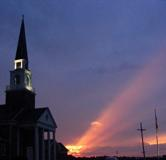

In [30]:
img = il[0];img

In [31]:
il[:1]

[<PIL.Image.Image image mode=RGB size=166x160 at 0x7F462F59AF28>]

# Split validation set

In [32]:
fn = il.items[0]; fn

PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_236.JPEG')

In [33]:
fn.parent.parent.name

'train'

In [34]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    # None value will be filtered out
    f = [o for o,m in zip(items, mask) if m==False]
    t = [o for o,m in zip(items, mask) if m==True]
    return f, t

In [35]:
splitter = partial(grandparent_splitter, valid_name='val')

In [36]:
%time train, valid = split_by_func(il, splitter)

CPU times: user 59.5 ms, sys: 0 ns, total: 59.5 ms
Wall time: 58.7 ms


In [37]:
len(train), len(valid)

(12894, 500)

Now that we can split our data, let's create the class that will contain it. It just needs two ItemList to be initialized, and we create a shortcut to all the unknown attributes by trying to grab them in the train ItemList.

In [38]:
#export
class SplitData():
    def __init__(self, train, valid): self.train, self.valid = train, valid

    def __getattr__(self, k): return getattr(self.train, k)
    # this is needed if we want to pickle split data and be able to load it back without recursion errors
    def __setstate__(self, data:Any): self.__dict__.update(data)
        
    @classmethod
    def split_by_func(cls, il, f):
        #il.new return path
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)
    
    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [39]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_236.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_16749.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_3254.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_5232.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_9317.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_7878.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_17263.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_8382.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_24899.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_20210.JPEG')...]
Path: /home/bf/.fastai/data/imagenette-160
Valid: ImageList (500 items)
[PosixPath

# Labeling

Labeling has to be done after splitting, because it uses training set information to apply to the validation set, using a Processor.

A Processor is a transformation that is applied to all the inputs once at initialization, with some state computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be processing texts to tokenize, then numericalize them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in tabular data, where we fill missing values with (for instance) the median computed on the training set. That statistic is stored in the inner state of the Processor and applied on the validation set.

In our case, we want to convert label strings to numbers in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this vocab.

In [40]:
#export 
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

First, let's define the processor. We also define a ProcessedItemList with an obj method that can get the unprocessed items: for instance a processed label will be an index between 0 and the number of classes - 1, the corresponding obj will be the name of the class. The first one is needed by the model for the training, but the second one is better for displaying the objects.

In [42]:
#export
class Processor():
    def process(self, items): return items
    
class CategoryProcessor(Processor):
    def __init__(self): self.vocab = None
        
    def __call__(self, items):
        # string to index
        # The vocab is defined on the first use
        if self.vocab is None:
            self.vocab = uniqueify(items)
            # object ot index
            self.otoi = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item): return self.otoi[item]
    
    # index to string
    # list of integer
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

Here we label according to the folders of the images, so simply fn.parent.name. We label the training set first with a newly created CategoryProcessor so that it computes its inner vocab on that set. Then we label the validation set using the same processor, which means it uses the same vocab. The end result is another SplitData object.

In [43]:
#export 
# parent folder is a label
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

class LabeledData():
    # make a new itemlist
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x, self.y = self.process(x, proc_x), self.process(y, proc_y)
        self.proc_x, self.proc_y = proc_x, proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self, idx): return self.x[idx], self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        # if int > get vocab, if list of int > get vocabs
        isint = isinstance(idx, int) or (isinstance(idx, torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item
    
    # dont need to instantiate the class
    # dont need lb = LabeledData()
    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        # pass il, _label_by_func to LabeledData 
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)
    
def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y) #processor has no vocab
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y) #have a vocab, use training set vocab
    return SplitData(train, valid)
    

In [44]:
#sd = SplitData.split_by_func(il, splitter); sd

In [45]:
# label list
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [46]:
assert ll.train.proc_y is ll.valid.proc_y

In [47]:
ll.train.y

ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /home/bf/.fastai/data/imagenette-160

In [48]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03028079', ['n03028079', 'n03028079'])

In [49]:
ll

SplitData
Train: LabeledData
x: ImageList (12894 items)
[PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_236.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_16749.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_3254.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_5232.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_9317.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_7878.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_17263.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_8382.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_24899.JPEG'), PosixPath('/home/bf/.fastai/data/imagenette-160/train/n03028079/n03028079_20210.JPEG')...]
Path: /home/bf/.fastai/data/imagenette-160
y: ItemList (12894 items

# Transform to tensor

In [50]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=166x160 at 0x7F462F59A940>, 0)

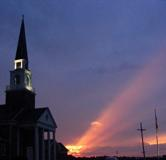

In [51]:
ll.train[0][0]

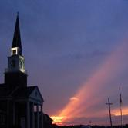

In [52]:
# Same batch needs same size
ll.train[0][0].resize((128, 128))

In [53]:
#export 
class ResizeFixed(Transform):
    _order = 10 
    def __init__(self, size):
        if isinstance(size, int): size=(size, size)
        self.size = size
    # call it will call Billinear resize
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)
    
# pillow to tensor faster
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h, w, -1).permute(2, 0, 1) #pillow channel last
to_byte_tensor._order = 20

# float
def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [54]:
# whole pipeline
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

Here is a little convenience function to show an image from the corresponding tensor.

In [55]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [56]:
x, y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

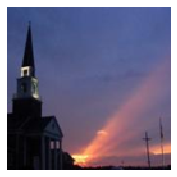

In [57]:
show_image(x)

# Modeling

DataBunch

Now we are ready to put our datasets together in a DataBunch

In [58]:
bs = 64

In [59]:
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=4)

In [60]:
x, y = next(iter(train_dl))

In [61]:
x.shape

torch.Size([64, 3, 128, 128])

'n03028079'

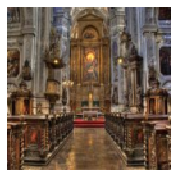

In [62]:
show_image(x[0])
ll.train.proc_y.vocab[y[0]]

In [63]:
y

tensor([0, 9, 0, 7, 5, 4, 9, 5, 8, 0, 7, 4, 1, 9, 5, 0, 4, 2, 6, 8, 6, 3, 1, 4,
        8, 7, 1, 4, 7, 0, 6, 8, 5, 9, 0, 7, 1, 3, 0, 5, 3, 9, 9, 6, 4, 0, 7, 5,
        5, 9, 9, 1, 5, 9, 2, 5, 0, 4, 6, 4, 3, 5, 0, 3])

We change a little bit our `DataBunch` to add a few attributes: `c_in` (for channel in) and `c_out` (for channel out) instead of just `c`. This will help when we need to build our model.

In [64]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl, valid_dl, c_in, c_out
    
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset

Then we define a function that goes directly from the SplitData to a DataBunch.

In [65]:
#export 
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

This gives us the full summary on how to grab our data and put it in a DataBunch:

In [66]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

# Imagelist 
il = ImageList.from_files(path, tfms=tfms)
# split data
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
# label list
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
# databunch
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

# Model

In [67]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback]

We will normalize with the statistics from a batch

In [68]:
m, s = x.mean((0,2,3)).cuda(), x.std((0,2,3)).cuda()
m,s

(tensor([0.4575, 0.4574, 0.4317], device='cuda:0'),
 tensor([0.2678, 0.2641, 0.2868], device='cuda:0'))

In [69]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[..., None, None]) / std[..., None, None]

#_m = tensor([0.47, 0.48, 0.45])
#_s = tensor([0.29, 0.28, 0.30])
_m = tensor([0.4575, 0.4574, 0.4317])
_s = tensor([0.2678, 0.2641, 0.2868])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [70]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [71]:
nfs = [64, 64, 128, 256]

We build our model using Bag of Tricks for Image Classification with Convolutional Neural Networks, in particular: we don't use a big conv 7x7 at first but three 3x3 convs, and don't go directly from 3 channels to 64 but progressively add those.

In [72]:
#export
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    # c_in * (3x3 kernel)
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [73]:
#sched = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.1, 0.3, 0.05))
sched = combine_scheds([0.3, 0.7], [sched_cos(0.1, 0.3), sched_cos(0.3, 0.05)])

In [74]:
learn, run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [75]:
#export
def model_summary(run, learn, data, find_all=False):
    xb, yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device
    xb, yb = xb.to(device), yb.to(device)
    # find all linear layer
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook, mod, inp, out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: learn.model(xb)

In [76]:
%time run.fit(5, learn)

train : [1.779976545534745, tensor(0.3799, device='cuda:0')]
valid : [1.8150135498046875, tensor(0.3980, device='cuda:0')]
train : [1.333577663302699, tensor(0.5500, device='cuda:0')]
valid : [1.249224853515625, tensor(0.5780, device='cuda:0')]
train : [1.010622218909958, tensor(0.6691, device='cuda:0')]
valid : [1.04419140625, tensor(0.6500, device='cuda:0')]
train : [0.747056982656662, tensor(0.7523, device='cuda:0')]
valid : [0.8588343505859375, tensor(0.7060, device='cuda:0')]
train : [0.5307447156259695, tensor(0.8360, device='cuda:0')]
valid : [0.8648773193359375, tensor(0.7200, device='cuda:0')]
CPU times: user 38.5 s, sys: 12.2 s, total: 50.8 s
Wall time: 2min 19s


In [77]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(

# Export

In [78]:
!python notebook2script.py 08_data_block.ipynb

Converted 08_data_block.ipynb to exp/nb_08.py
